# Shallow Moments with topography (Simple)

## Imports

In [11]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import jax
from jax import numpy as jnp
import pytest
from types import SimpleNamespace
from sympy import cos, pi, Piecewise

from library.fvm.solver import HyperbolicSolver, Settings
from library.fvm.ode import RK1
import library.fvm.reconstruction as recon
import library.fvm.timestepping as timestepping
import library.fvm.flux as flux
import library.fvm.nonconservative_flux as nc_flux
from library.model.boundary_conditions import BoundaryCondition
from library.model.models.basisfunctions import Basisfunction, Legendre_shifted
from library.model.models.basismatrices import Basismatrices
from library.misc.misc import Zstruct

from library.model.models.shallow_moments_topo import ShallowMomentsTopo, ShallowMomentsTopoNumerical
from library.model.models.shallow_moments import ShallowMoments2d,,

import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
import library.misc.io as io
from library.mesh.mesh import compute_derivatives
from tests.pdesoft import plots_paper
import library.postprocessing.visualization as visu


import library.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
from library.mesh.mesh import convert_mesh_to_jax
import argparse

SyntaxError: invalid syntax (3119489780.py, line 25)

## Model

In [2]:
level = 1
offset = 1+level
n_fields = 3 + 2 * level
settings = Settings(
    name="SME",
    output=Zstruct(
        directory=f"outputs/junction_{level}", filename="SME", output_snapshots=30
    ),
)

2025-08-28 16:59:25.249 | WARNING  | library.misc.misc:__init__:146 - No 'clean_directory' attribute found in output Zstruct. Default: False


In [3]:
inflow_dict = { 
    1: lambda t, x, dx, q, qaux, p, n: Piecewise((0.1, t < 0.2),(q[0], True)),
    2: lambda t, x, dx, q, qaux, p, n: Piecewise((-0.3, t < 0.2),(-q[1], True)),
                }
inflow_dict.update({
    2+i: lambda t, x, dx, q, qaux, p, n: 0 for i in range(level)
})
inflow_dict.update({
    1+offset+i: lambda t, x, dx, q, qaux, p, n: 0 for i in range(level+1)
})

bcs = BC.BoundaryConditions(
    [
        BC.Lambda(physical_tag="inflow", prescribe_fields=inflow_dict),
        BC.Wall(physical_tag="wall"),
    ]
)

def custom_ic(x):
    Q = np.zeros(4 + 2 * level, dtype=float)
    Q[1] = 0.01
    return Q

ic = IC.UserFunction(custom_ic)

model = ShallowMomentsTopoNumerical(
    level=level,
    boundary_conditions=bcs,
    initial_conditions=ic,
)

main_dir = os.getenv("ZOOMY_DIR")
mesh = petscMesh.Mesh.from_gmsh(
    os.path.join(main_dir, "meshes/channel_junction/mesh_2d_coarse.msh")
    # os.path.join(main_dir, "meshes/channel_junction/mesh_2d_fine.msh")
)

mesh = convert_mesh_to_jax(mesh)
class SMESolver(HyperbolicSolver):
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):
        dudx = compute_derivatives(Q[2]/Q[1], mesh, derivatives_multi_index=[[0, 0]])[:,0]
        dvdy = compute_derivatives(Q[2+offset]/Q[1], mesh, derivatives_multi_index=[[0, 1]])[:,0]
        Qaux = Qaux.at[0].set(dudx)
        Qaux = Qaux.at[1].set(dvdy)
        return Qaux
solver = SMESolver(settings=settings, time_end=0.01)

Time compute matrices: 0.13579154014587402



In [6]:
model.basismatrices.M

array([[1.        , 0.        ],
       [0.        , 0.33333333]])

In [8]:
import sympy

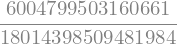

In [ ]:
sympy.Rational(model.basismatrices.M[1,1])

## Solve

In [5]:
Qnew, Qaux = solver.solve(mesh, model)

Time compute matrices: 0.11829376220703125


MatrixError: It is not always possible to express the eigenvalues of a matrix of size 5x5 or higher in radicals. We have CRootOf, but domains other than the rationals are not currently supported. If there are no symbols in the matrix, it should still be possible to compute numeric approximations of the eigenvalues using M.evalf().eigenvals() or M.charpoly().nroots().

## Visualization

In [ ]:
io.generate_vtk(os.path.join(settings.output.directory, f"{settings.output.filename}.h5"))
postprocessing.vtk_interpolate_3d(model, settings, Nz=20, filename='out_3d')

2025-08-28 16:29:43.888 | INFO     | library.postprocessing.postprocessing:vtk_interpolate_3d:62 - Converted snapshot 0/3
2025-08-28 16:29:43.933 | INFO     | library.postprocessing.postprocessing:vtk_interpolate_3d:62 - Converted snapshot 1/3
2025-08-28 16:29:43.973 | INFO     | library.postprocessing.postprocessing:vtk_interpolate_3d:62 - Converted snapshot 2/3
2025-08-28 16:29:44.390 | INFO     | library.postprocessing.postprocessing:vtk_interpolate_3d:65 - Output is written to: /home/ingo/Git/Zoomy/outputs/junction_0/out_3d.h5/out_3d.*.vtk


In [ ]:
visu.pyvista_3d(settings.output.directory, scale=1.0)

Row
    [0] Column(width=250)
        [0] Markdown(str)
        [1] IntSlider(end=2, name='Time Step', sizing_mode='stretch_width')
        [2] Select(options=['0', '1', '2', ...], sizing_mode='stretch_width', value='0')
        [3] Checkbox(name='Show Mesh')
    [1] Spacer(width=5)
    [2] Column
        [0] VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='5b4...], height=500, sizing_mode='stretch_width')